In [42]:
import moments
import demes
import demesdraw
import matplotlib.pyplot as plt
import pickle
import gzip
from IPython.display import Markdown as md
import warnings

# Function for printing syntax-highlighted YAML demes models
# If there is a better way to do this, tell me!!
def print_model(file_path):
    with open(file_path) as f:
        lines = f.read()
    return md("```yaml\n" + lines + "```")
warnings.filterwarnings('ignore')

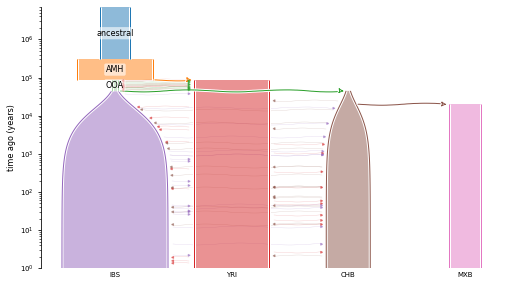

In [47]:
# this file contains the parametrization of the model
america_expanions_yml = "./ooa-4pops.yml"
america_expansion = demes.load(america_expanions_yml)
demesdraw.tubes(america_expansion, log_time=True)
plt.show();

In [49]:
print_model(america_expanions_yml)

```yaml
description: The Gutenkunst et al. (2009) three-population model of human history,
  modified by replacing CEU with IBS.
time_units: years
generation_time: 29
doi: ['https://doi.org/10.1371/journal.pgen.1000695']
demes:
- name: ancestral
  description: Equilibrium/root population
  epochs:
  - {end_time: 300983.61910865706, start_size: 9593.315822139859}
- name: AMH
  description: Anatomically modern humans
  ancestors: [ancestral]
  epochs:
  - {end_time: 86978.93529450893, start_size: 23512.69146204261}
- name: OOA
  description: Bottleneck out-of-Africa population
  ancestors: [AMH]
  epochs:
  - {end_time: 44748.23862033427, start_size: 2056.5730700064346}
- name: YRI
  description: Yoruba in Ibadan, Nigeria
  ancestors: [AMH]
  epochs:
  - {end_time: 0, start_size: 23512.69146204261}
- name: IBS
  description: Iberian populations in Spain (IBS).
  ancestors: [OOA]
  epochs:
  - {end_time: 0, start_size: 2130.4390581666967, end_size: 32956.374504334126}
- name: CHB
  description: Han Chinese in Beijing, China
  ancestors: [OOA]
  epochs:
  - {end_time: 0, start_size: 1338.9282421410517, end_size: 13677.905103953248}
- name: MXB
  description: Native American,  Mexico.
  ancestors: [CHB]
  start_time: 20000
  epochs:
  - {end_time: 0, start_size: 10000}

migrations:
- demes: [YRI, IBS]
  rate: 3.256463068676266e-05
- demes: [YRI, CHB]
  rate: 1.6414195981495537e-05
- demes: [IBS, CHB]
  rate: 7.69081279717762e-05
- {source: YRI, dest: OOA, rate: 9.885227357176779e-05}
- {source: OOA, dest: YRI, end_time: 44748.23862033427, rate: 9.885227357176779e-05}
```

## SFS inference

In [52]:
options = "./ooa4pos_options.yaml"
print_model(options)

```yaml
# Parametrization for OOA model with Native American expansion
# OOA 3 pop model parameters have been fixed. Here, we only include
# the new parameters for the Native American expansion
parameters:
- name: TN
  description: Time of MXB branching from CHB.
  upper_bound: 44748.24
  values:
  - demes:
      MXB:
        epochs:
          0: end_time
- name: NCmxb
  description: Population size for MXB (Native American) populations
  values:
  - demes:
      MXB:
        epochs:
          0: start_size
```

In [53]:
# Load the pre-computed SFS (SYNONYMOUS VARIANTS)
# and marginalize for the 4 populations
sf = "../../data/210804-Compute-jSFS/data/spectrums/5d-csq-synonymous-spectrum.pkl.gz"
with gzip.open(sf, "rb") as f:
    sf = pickle.load(f)

print(sf.pop_ids)

['CHB', 'IBS', 'MXB', 'MXL', 'YRI']


In [54]:
# This spectrum is 5-dimensional, now I marginalize to keep
# the main populations
sf = sf.marginalize([3])
print(sf.pop_ids)
print(sf.shape)

['CHB', 'IBS', 'MXB', 'YRI']
(51, 51, 51, 51)


In [56]:
# project
n = 35
sf = sf.project([n, n, n, n])

# fold
sf = sf.fold()

## Optimization

In [ ]:
otuput = "ooa-America_best_fit_model.yml"
uL = 0.14419746897690008
output = "./results/ooa_best_fit_model.yml"
ret = moments.Demes.Inference.optimize(
    deme_graph=america_expanions_yml,
    output=output,
    inference_options=options,
    data=sf,
    verbose=30,
    maxiter=1000,
    uL=uL,
    overwrite=True
)

## Results

In [ ]:
param_names, opt_params, LL = ret
print("Log-likelihood:", -LL)
print("Best fit parameters")
for n, p in zip(param_names, opt_params):
    print(f"{n}\t{p:.3}")